In [202]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
x = mnist.data
y = mnist.target

In [223]:
import numpy as np

train_mask = np.where((y == '5') | (y == '8'))

train, target = x[train_mask], y[train_mask]


L2_norms = np.linalg.norm(train, ord = 2, axis=1)

train = train/(L2_norms.max())



In [224]:

target[target=='5'] = 1
target[target=='8'] = 0

print(target)

target = target.astype('float')

[1 1 0 ... 1 0 1]


In [225]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1) 



In [226]:
print((y_train==1.0).shape)

(9196,)


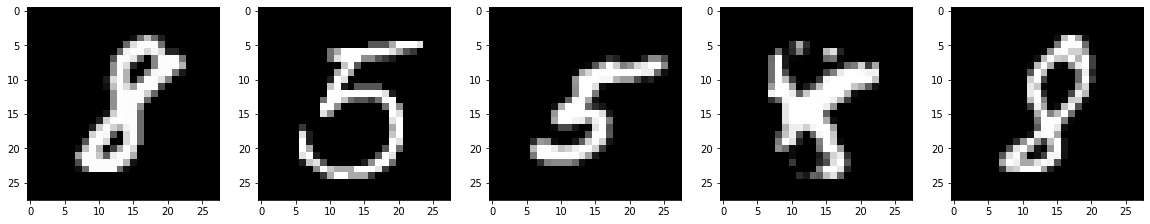

In [227]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(X_train[0:5], 
                                           y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)

In [228]:
class LogisticRegression(object):
    """
    Logistic Regression Classifier
    """
    def __init__(self, max_iter=5000):
        self.max_iter       = max_iter

    # Defining Sigmoid Function
    def sigmoid_activation(self, result):
        # result = result.astype('float')
        final_result = 1/(1+np.exp(-result))
        return final_result
    # Optimizing the model by calculating the cost and gradient
    def model_optimize(self, w, X, Y, reg_par):
        # Number of samples
        m = X.shape[0]
        
        # Prediction
        final_result = self.sigmoid_activation(np.dot(w,X.T))
        Y_T = Y.T

        # Defining the regularized cost function
        cost = (-1/m)*(np.sum((Y_T*np.log(final_result)) + ((1-Y_T)*(np.log(1-final_result))))) + (reg_par / (2 * m)) * np.sum(np.square(w[1:]))

        # Gradient calculation
        dw = (1/m)*(np.dot(X.T, (final_result-Y.T).T))-((reg_par*w.T/m))
        
        grads = {"dw": dw}
        
        return grads, cost

    # At each iteration calculate the cost and gradients value, update the weights until the stopping criteria is flfilled     
    def fit(self, w, X, Y, X_v , Y_v, learning_rate, no_iterations, reg_par, tol):
        costs = []
        costs_val = []
        dw = []
        normJ = []
        # Calculating the number of iterations required to converge the algorithm
        reqit = no_iterations
        # Iterate until the convergence is reached
        for i in range(no_iterations):
            # calculate training gradient and cost function for ith iteration
            grads, cost = self.model_optimize(w,X,Y,reg_par)
            # calculate validation gradient and cost function for ith iteration
            grads_val, cost_val = self.model_optimize(w,X_v,Y_v,reg_par)
            # find the change in gradients 
            dw = grads["dw"]
            # find the overall change in gradient. This is needed to stop the algorithm. If the change is gradients is not changing much we will stop the algorithm.
            normJp=(np.sqrt(np.sum(np.square(dw))))
            
            # weight update
            w = w - (learning_rate * (dw.T))
            # find the value of cost and change in gradients at each tenth iterations. (e.g. at i = 10, 20 ,30,....,10*n)
            if (i % 10 == 0):
                normJ.append(normJp)
            if (i % 10 == 0):
                costs_val.append(cost_val)       
            if (i % 10 == 0):
                costs.append(cost)
            # Stopping Criteria ( The iteration will be stopped if we see that he change in gradient is much less than a small number 'tol' which means that the gradient is not updating much.)
            if (np.max(np.abs(dw)) < tol):
              cost = cost
              cost_val = cost_val
              reqit = i
              break
            else:
              continue

        #final parameters
        coeff = {"w": w}
        gradient = {"dw": dw}
        
        return reqit, coeff, normJ, costs, costs_val
    # Predict the Response. If the model prediction is greater than a threshold value then it will set the classifier to identify the sample as a positive class sample. If not then do otherwise.   
    def predict(self, final_pred, m, threshold):
        y_pred = np.zeros((1,m))
        y_pred[final_pred>threshold] = 1

        return y_pred

In [229]:
class GaussianLogisticRegression(object):
    """
    Logistic Regression Classifier with Gaussian privacy mechanism
    """
    def __init__(self, max_iter=5000):
        self.max_iter = max_iter

    # Defining Sigmoid Function
    def sigmoid_activation(self, result):
        result = result.astype('float')
        final_result = 1/(1+np.exp(-result))
        return final_result
    # Optimizing the model by calculating the cost and gradient
    def model_optimize(self, w, X, Y, reg_par, epsilon, delta):
        # Number of samples
        m = X.shape[0]

        # calclate sensitivity
        delf = 2/m

        ## calculate mean absolte deviation MAD of laplacian density function
        sigma = (delf/epsilon) * np.sqrt(2 * np.log(1.25/delta))

        # create the noise term from normal distribution
        noise = sigma * np.random.randn(X.shape[1],1)

        final_result = self.sigmoid_activation(np.dot(w,X.T))
        Y_T = Y.T
        #Gradient calculation
        dw = ((1/m)*(np.dot(X.T, (final_result-Y.T).T)))-((reg_par*w.T/m)) 
        dw = dw + noise
        grads = {"dw": dw}


        #Prediction


        # Defining the regularized cost function
        cost = (-1/m)*(np.sum((Y_T*np.log(final_result)) + ((1-Y_T)*(np.log(1-final_result))))) + (reg_par / (2 * m)) * np.sum(np.square(w[1:]))

        return grads, cost
    # At each iteration calculate the cost and gradients value, update the weights until the stopping criteria is flfilled     
    def fit(self, w, X, Y, X_v , Y_v, learning_rate, no_iterations, reg_par, tol, epsilon, delta):
        costs = []
        costs_val = []
        normJ = []
        # Calculating the number of iterations required to converge the algorithm
        reqit = no_iterations
        # Iterate until the convergence is reached
        for i in range(no_iterations):
            # calculate training gradient and cost function for ith iteration
            grads, cost = self.model_optimize(w,X,Y,reg_par,epsilon,delta)
            # calculate validation cost for ith iteration
            _ , cost_val = self.model_optimize(w,X_v,Y_v,reg_par,epsilon,delta)
            # find the change in gradients 
            dw = grads["dw"]
            # find the overall change in gradient. This is needed to stop the algorithm. If the change is gradients is not changing much we will stop the algorithm.
            normJp=(np.sqrt(np.sum(np.square(dw))))
            # weight update
            w = w - (learning_rate * (dw.T))
            # find the value of cost and change in gradients at each tenth iterations. (e.g. at i = 10, 20 ,30,....,10*n)
            if (i % 10 == 0):
                normJ.append(normJp)
            if (i % 10 == 0):
                costs_val.append(cost_val)       
            if (i % 10 == 0):
                costs.append(cost)
            # Stopping Criteria ( The iteration will be stopped if we see that he change in gradient is much less than a small number 'tol' which means that the gradient is not updating much.)
            if (np.max(np.abs(dw)) < tol):
              cost = cost
              cost_val = cost_val
              reqit = i
              break
            else:
              continue

        #final parameters
        coeff = {"w": w}
        gradient = {"dw": dw}
        
        return reqit, coeff, normJ, costs, costs_val
    # Predict the Response. If the model prediction is greater than a threshold value then it will set the classifier to identify the sample as a positive class sample. If not then do otherwise.   
    def predict(self, final_pred, m, threshold):
        y_pred = np.zeros((1,m))
        y_pred[final_pred>threshold] = 1

        return y_pred

In [231]:
from sklearn.metrics import accuracy_score

# weight initialization
def weightInitialization(n_features):
        w = np.zeros((1,n_features))
        return w

n_features = X_train.shape[1]
w = weightInitialization(n_features)

iter,coeff, gradient, costs, costs_val = LogisticRegression().fit(w, X_train, y_train, X_val, y_val, learning_rate=0.1,no_iterations=1500, reg_par = 100, tol = 1e-5)
w = weightInitialization(n_features)
iter_gau,coeff_gau, gradient_gau, costs_gau, costs_val_gau = GaussianLogisticRegression().fit(w, X_train, y_train, X_val, y_val, learning_rate=0.1, no_iterations=1500, reg_par = 100, tol = 1e-4, epsilon = 0.01, delta = 1e-5)
w = coeff["w"]

w_gau = coeff_gau["w"]

final_train_pred = LogisticRegression().sigmoid_activation(np.dot(w,X_train.T))
final_test_pred = LogisticRegression().sigmoid_activation(np.dot(w,X_val.T))

#
final_train_pred_gau = GaussianLogisticRegression().sigmoid_activation(np.dot(w_gau,X_train.T))
final_test_pred_gau = GaussianLogisticRegression().sigmoid_activation(np.dot(w_gau,X_val.T))


m_tr =  X_train.shape[0]
m_ts =  X_val.shape[0]
#
y_tr_pred = LogisticRegression().predict(final_train_pred, m_tr, 0.5)
y_tr_pred = y_tr_pred.T 
print('Training Accuracy of non-priv',accuracy_score(y_tr_pred, y_train))


y_tr_pred_gau = GaussianLogisticRegression().predict(final_train_pred_gau, m_tr, 0.5)
y_tr_pred_gau = y_tr_pred_gau.T 
print('Training Accuracy of Gaussian',accuracy_score(y_tr_pred_gau, y_train))

#
y_ts_pred = LogisticRegression().predict(final_test_pred, m_ts, 0.5)
y_ts_pred = y_ts_pred.T 
print('Validation Accuracy of non-priv',accuracy_score(y_ts_pred, y_val))

y_ts_pred_gau = GaussianLogisticRegression().predict(final_test_pred_gau, m_ts, 0.5)
y_ts_pred_gau = y_ts_pred_gau.T 
print('Validation Accuracy of Gaussian',accuracy_score(y_ts_pred_gau, y_val))

Training Accuracy of non-priv 0.9150717703349283
Training Accuracy of Gaussian 0.8801652892561983
Validation Accuracy of non-priv 0.9178082191780822
Validation Accuracy of Gaussian 0.8896499238964992


Test Accuracy at 0.1 threshold is0.578386605783866
Test Accuracy at 0.2 threshold is0.7815829528158296
Test Accuracy at 0.3 threshold is0.8763318112633182
Test Accuracy at 0.4 threshold is0.9204718417047184
Test Accuracy at 0.5 threshold is0.9208523592085236
Test Accuracy at 0.6 threshold is0.8633942161339422
Test Accuracy at 0.7 threshold is0.754185692541857
Test Accuracy at 0.8 threshold is0.630517503805175
Test Accuracy at 0.9 threshold is0.5372907153729072
Test Accuracy at 0.1 threshold is0.6263318112633182
Test Accuracy at 0.2 threshold is0.7861491628614916
Test Accuracy at 0.3 threshold is0.8649162861491628
Test Accuracy at 0.4 threshold is0.8938356164383562
Test Accuracy at 0.5 threshold is0.8812785388127854
Test Accuracy at 0.6 threshold is0.8276255707762558
Test Accuracy at 0.7 threshold is0.7423896499238964
Test Accuracy at 0.8 threshold is0.6293759512937596
Test Accuracy at 0.9 threshold is0.541095890410959


<Figure size 432x288 with 0 Axes>

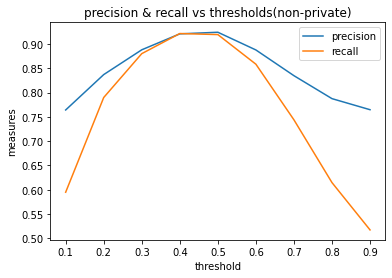

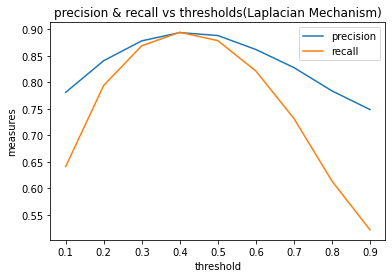

<Figure size 432x288 with 0 Axes>

In [232]:
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
%matplotlib inline


thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = []
recalls = []
precisions_gau = []
recalls_gau = []
for i in thresholds:
  final_test_pred = LogisticRegression().sigmoid_activation(np.dot(w,X_test.T))
  m_ts =  X_test.shape[0]
  y_ts_pred = LogisticRegression().predict(final_test_pred, m_ts, i)
  y_ts_pred = y_ts_pred.T 
  print('Test Accuracy at '+ str(i)+ ' threshold is' + str(accuracy_score(y_ts_pred, y_test)))
  precisions.append(precision_score(y_test, y_ts_pred, average='macro'))
  recalls.append(recall_score(y_test, y_ts_pred, average='macro'))

plt.plot(thresholds,precisions)
plt.plot(thresholds,recalls)
plt.ylabel('measures')
plt.xlabel('threshold')
plt.title('precision & recall vs thresholds(non-private)')
plt.legend(["precision", "recall"])
plt.figure()



for i in thresholds:
  final_test_pred_gau = GaussianLogisticRegression().sigmoid_activation(np.dot(w_gau,X_test.T))
  m_ts =  X_test.shape[0]
  y_ts_pred_gau = GaussianLogisticRegression().predict(final_test_pred_gau, m_ts, i)
  y_ts_pred_gau = y_ts_pred_gau.T 
  print('Test Accuracy at '+ str(i)+ ' threshold is' + str(accuracy_score(y_ts_pred_gau, y_test)))
  precisions_gau.append(precision_score(y_test, y_ts_pred_gau, average='macro'))
  recalls_gau.append(recall_score(y_test, y_ts_pred_gau, average='macro'))

plt.plot(thresholds,precisions_gau)
plt.plot(thresholds,recalls_gau)
plt.ylabel('measures')
plt.xlabel('threshold')
plt.title('precision & recall vs thresholds(Laplacian Mechanism)')
plt.legend(["precision", "recall"])
plt.figure()

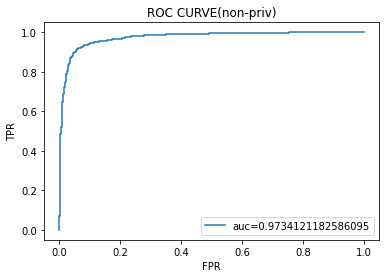

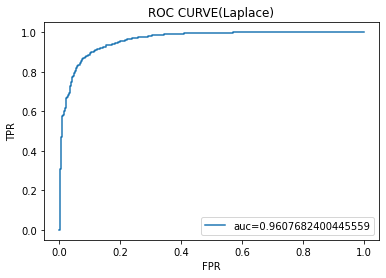

In [233]:
scores = LogisticRegression().sigmoid_activation(np.dot(w,X_test.T))
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores.T, pos_label=1)
auc = metrics.roc_auc_score(y_test, scores.T)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(loc=4)
plt.title('ROC CURVE(non-priv)')
plt.figure()


scores_gau = GaussianLogisticRegression().sigmoid_activation(np.dot(w_gau,X_test.T))
fpr_gau, tpr_gau, thresholds_gau = metrics.roc_curve(y_test, scores_gau.T, pos_label=1)
auc = metrics.roc_auc_score(y_test, scores_gau.T)
plt.plot(fpr_gau,tpr_gau,label="auc="+str(auc))
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(loc=4)
plt.title('ROC CURVE(Laplace)')
plt.show()




<Figure size 432x288 with 0 Axes>

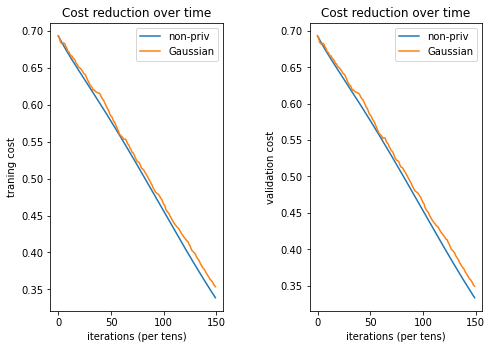

<Figure size 432x288 with 0 Axes>

In [234]:
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(1, 2, 1)
plt.plot(costs)
plt.plot(costs_gau)
plt.ylabel('traning cost')
plt.xlabel('iterations (per tens)')
plt.title('Cost reduction over time')
plt.legend(["non-priv","Gaussian"])


plt.subplot(1, 2, 2)
plt.plot(costs_val)
plt.plot(costs_val_gau)
plt.ylabel('validation cost')
plt.xlabel('iterations (per tens)')
plt.title('Cost reduction over time')
plt.legend(["non-priv","Gaussian"])


plt.subplots_adjust(left=0.5,
                    bottom=0.5, 
                    right=1.5, 
                    top=1.5, 
                    wspace=0.5, 
                    hspace=0.5)
plt.figure()

<Figure size 432x288 with 0 Axes>

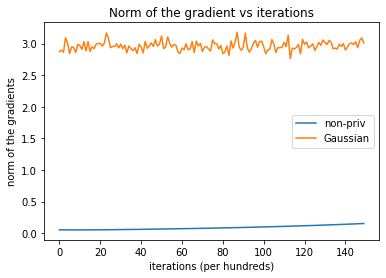

<Figure size 432x288 with 0 Axes>

In [235]:

plt.plot(gradient)
plt.plot(gradient_gau)
plt.ylabel('norm of the gradients')
plt.xlabel('iterations (per hundreds)')
plt.legend(['non-priv','Gaussian'])
plt.title('Norm of the gradient vs iterations')
plt.figure()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply


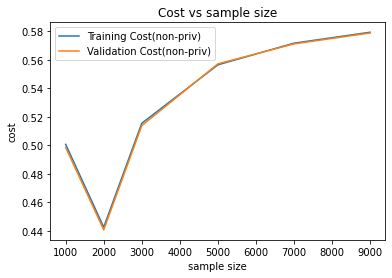

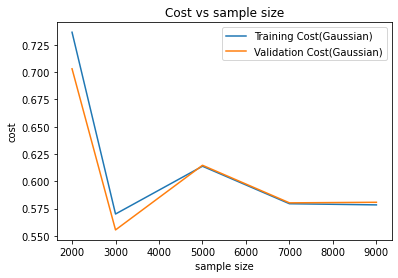

In [237]:
costsam = []
valcostsam = []
costsamgau = []
valcostsamgau = []


j = [1000, 2000, 3000, 5000, 7000, 9000]

for i in j:
  w = weightInitialization(n_features)
  iter, coeff, gradient, costs, costs_val = LogisticRegression().fit(w, X_train[1:i,:], y_train[1:i], X_val, y_val, learning_rate=0.1, no_iterations=500, reg_par = 100, tol = 1e-5)  
  w = weightInitialization(n_features)
  iter_gau, coeff_gau, gradient_gau, costs_gau, costs_val_gau = GaussianLogisticRegression().fit(w, X_train[1:i,:], y_train[1:i], X_val, y_val, learning_rate=0.1, no_iterations=500, reg_par = 100, tol = 1e-4, epsilon = 0.01, delta=1e-5)  
  costsam.append(costs[-1])
  valcostsam.append(costs_val[-1])
  costsamgau.append(costs_gau[-1])
  valcostsamgau.append(costs_val_gau[-1])


plt.plot(j,costsam)
plt.plot(j,valcostsam)
plt.ylabel('cost')
plt.xlabel('sample size')
plt.title('Cost vs sample size')
plt.legend(["Training Cost(non-priv)", "Validation Cost(non-priv)"])
plt.show()

plt.plot(j,costsamgau)
plt.plot(j,valcostsamgau)
plt.ylabel('cost')
plt.xlabel('sample size')
plt.title('Cost vs sample size')
plt.legend(["Training Cost(Gaussian)", "Validation Cost(Gaussian)"])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: in

<Figure size 432x288 with 0 Axes>

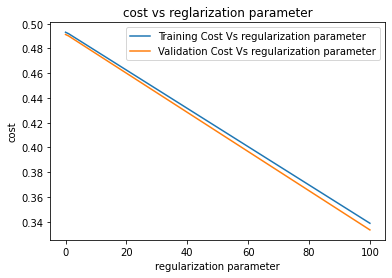

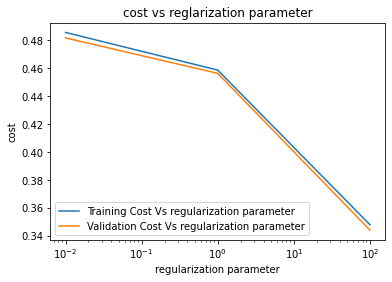

<Figure size 432x288 with 0 Axes>

In [239]:


costslam = []
valcostslam = []
costslamgau = []
valcostslamgau = []

j =  [0.01, 1, 100, 10000, 1e6]
for i in j:
  w= weightInitialization(n_features)
  iter,coeff, gradient, costs, costs_val = LogisticRegression().fit(w, X_train, y_train, X_val, y_val, learning_rate=0.1, no_iterations=1500, reg_par = i, tol = 1e-5)
  costslam.append(costs[-1])
  valcostslam.append(costs_val[-1])
  
for i in j:
  w = weightInitialization(n_features)
  iter_gau,coeff_gau, gradient_gau, costs_gau, costs_val_gau = GaussianLogisticRegression().fit(w, X_train, y_train, X_val, y_val, learning_rate=0.1, no_iterations=1500, reg_par = i, tol = 1e-4, epsilon = 0.01, delta = 1e-5)
  costslamgau.append(costs_gau[-1])
  valcostslamgau.append(costs_val_gau[-1])

plt.plot(j,costslam)
plt.plot(j,valcostslam)
plt.ylabel('cost')
plt.xlabel('regularization parameter')
plt.title('cost vs reglarization parameter')
plt.legend(["Training Cost Vs regularization parameter", "Validation Cost Vs regularization parameter"])
plt.figure()

plt.semilogx(j,costslamgau)
plt.semilogx(j,valcostslamgau)
plt.ylabel('cost')
plt.xlabel('regularization parameter')
plt.title('cost vs reglarization parameter')
plt.legend(["Training Cost Vs regularization parameter", "Validation Cost Vs regularization parameter"])
plt.figure()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply


Text(0.5, 1.0, 'Required Iterations vs step size')

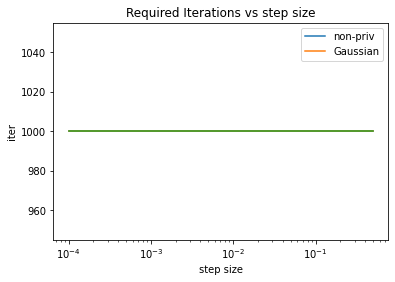

In [247]:
j =  [1e-4, 1e-2, 1e-1, 0.1, 0.5]
iters = []
itersgau = []
for i in j:
  w = weightInitialization(n_features)
  iter, coeff, gradient, costs, costs_val = LogisticRegression().fit(w, X_train, y_train, X_val, y_val, learning_rate=i, no_iterations=1000, reg_par = 100, tol = 1e-3) 
  iters.append(iter)

plt.plot(j,iters)
plt.ylabel('iter')
plt.xlabel('step size')
plt.title('Reqired Iterations vs step size')


for i in j:
  w = weightInitialization(n_features)
  iter_gau, coeff_gau, gradient_gau, costs_gau, costs_val_gau = GaussianLogisticRegression().fit(w, X_train, y_train, X_val, y_val, learning_rate=i, no_iterations=1000, reg_par = 100, tol = 1e-3, epsilon = 0.01, delta = 1e-5)  
  itersgau.append(iter_gau)

plt.semilogx(j,iters)
plt.semilogx(j,itersgau)
plt.ylabel('iter')
plt.xlabel('step size')
plt.legend(['non-priv','Gaussian'])
plt.title('Required Iterations vs step size')


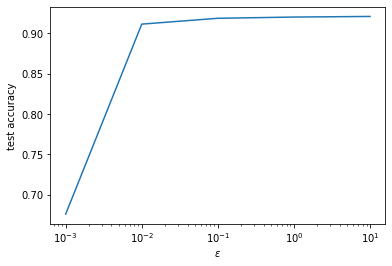

In [220]:
epsilon_all = [1e-3, 1e-2, 1e-1, 1, 10]

# accuracy = []
accuracy_gau = []
m_ts = X_test.shape[0]
for i in epsilon_all:
  w = weightInitialization(n_features)
  iter,coeff, gradient, costs, costs_val = LogisticRegression().fit(w, X_train, y_train, X_val, y_val, learning_rate=0.1,no_iterations=1500, reg_par = 100, tol = 1e-5)
  w = weightInitialization(n_features)
  iter_gau,coeff_gau, gradient_gau, costs_gau, costs_val_gau = GaussianLogisticRegression().fit(w, X_train, y_train, X_val, y_val, learning_rate=0.1, no_iterations=1500, reg_par = 100, tol = 1e-5, epsilon = i, delta = 1e-5)
  w = coeff["w"]
  w_gau = coeff_gau["w"]
  final_test_pred = LogisticRegression().sigmoid_activation(np.dot(w,X_test.T))
  final_test_pred_gau = GaussianLogisticRegression().sigmoid_activation(np.dot(w_gau,X_test_L2.T))
  y_ts_pred = LogisticRegression().predict(final_test_pred, m_ts, 0.5)
  y_ts_pred = y_ts_pred.T 
  accuracy.append(accuracy_score(y_ts_pred, y_test))
  y_ts_pred_gau = GaussianLogisticRegression().predict(final_test_pred_gau, m_ts, 0.5)
  y_ts_pred_gau = y_ts_pred_gau.T 
  accuracy_gau.append(accuracy_score(y_ts_pred_gau, y_test))

plt.semilogx(epsilon_all,accuracy)
plt.semilogx(epsilon_all,accuracy_gau)
plt.ylabel('test accuracy')
plt.xlabel('$\epsilon$')
plt.legend(["non-priv", "Gaussian"])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply


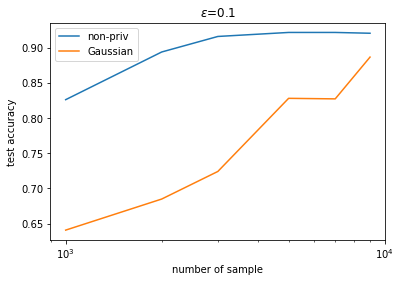

In [221]:
j = [1000, 2000, 3000, 5000, 7000, 9000]


accuracy = []
accuracy_gau = []
m_ts = X_test.shape[0]
for i in j:
  w = weightInitialization(n_features)
  iter,coeff, gradient, costs, costs_val = LogisticRegression().fit(w, X_train[1:i,:], y_train[1:i], X_val, y_val, learning_rate=0.1,no_iterations=1500, reg_par = 100, tol = 1e-4)
  w = weightInitialization(n_features)
  iter_gau,coeff_gau, gradient_gau, costs_gau, costs_val_gau = GaussianLogisticRegression().fit(w, X_train[1:i,:], y_train[1:i], X_val, y_val, learning_rate=0.1, no_iterations=1500, reg_par = 100, tol = 1e-4, epsilon = 0.01, delta = 1e-5)
  w = coeff["w"]
  w_gau = coeff_gau["w"]
  final_test_pred = LogisticRegression().sigmoid_activation(np.dot(w,X_test.T))
  final_test_pred_gau = GaussianLogisticRegression().sigmoid_activation(np.dot(w_gau,X_test_L2.T))
  y_ts_pred = LogisticRegression().predict(final_test_pred, m_ts, 0.5)
  y_ts_pred = y_ts_pred.T 
  accuracy.append(accuracy_score(y_ts_pred, y_test))
  y_ts_pred_gau = GaussianLogisticRegression().predict(final_test_pred_gau, m_ts, 0.5)
  y_ts_pred_gau = y_ts_pred_gau.T 
  accuracy_gau.append(accuracy_score(y_ts_pred_gau, y_test))

plt.semilogx(j,accuracy)
plt.semilogx(j,accuracy_gau)
plt.ylabel('test accuracy')
plt.xlabel('number of sample')
plt.title('$\epsilon$=0.1')
plt.legend(["non-priv", "Gaussian"])
plt.show()
